# Simple Genetic Algorithm

In [1]:
using Pkg
Pkg.activate("/home/lism8025/Documents/Projects/GeneticDeorbit")

  Activating project at `~/Documents/Projects/GeneticDeorbit`


In [2]:
using Distributed 
@everywhere using GeneticDeorbit
@everywhere using Evolutionary
@everywhere import Evolutionary: trace!
@everywhere using Distributions, Random

In [3]:
# custom result trace
function trace!(record::Dict{String,Any}, objfun, state, population, method, options)
    record["state"] = deepcopy(state)
    record["objfun"] = deepcopy(objfun)
    record["population"] = deepcopy(population)
end

trace! (generic function with 3 methods)

In [4]:
function rand_x0() 
    return [rand(Uniform(lower[1], upper[1])), rand(Uniform(lower[2], upper[2]))]
end

# selection function picks top N of population
function myselection
end

# crossover function averages values
function mycrossover(v1::T, v2::T; rng::AbstractRNG=Random.default_rng()) where {T <: AbstractVector}
    c1 = (v1+v2)./2
    return c1, copy(c1)
end

# mutation function sometimes creates new random offspring
function mymutation(v1::T; rng::AbstractRNG=Random.default_rng()) where {T <: AbstractVector}
    return rand_x0()
end

mymutation (generic function with 1 method)

In [5]:
# Params
weights = [0.5, 0.5] # 50% on time, 50% on throttle
lower = [250.0e3, 0.0]
upper = [450.0e3, pi]

# Optimize
result = Evolutionary.optimize(
         x-> eval_fitness_val(x,weights),
         BoxConstraints(lower, upper),
         rand_x0,
         GA(populationSize = 20, 
            selection = rouletteinv,
            crossover = AX, 
            mutation = mymutation,
            epsilon = 4
            ),
         Evolutionary.Options(iterations=500,
                              time_limit=120*60.0,
                              store_trace = true,
                              show_trace = false,
                              parallelization=:thread, # :serial, :thread
                              )
         ) 


 * Status: success

 * Candidate solution
    Minimizer:  [436061.7091726196, 2.400021721839083]
    Minimum:    1.036661e6
    Iterations: 22

 * Found with
    Algorithm: GA[P=20,x=0.8,μ=0.1,ɛ=4]

 * Convergence measures
    |f(x) - f(x')| = 0.0 ≤ 1.0e-12

 * Work counters
    Seconds run:   7471.2134 (vs limit 7200.0)
    Iterations:    22
    f(x) calls:    456


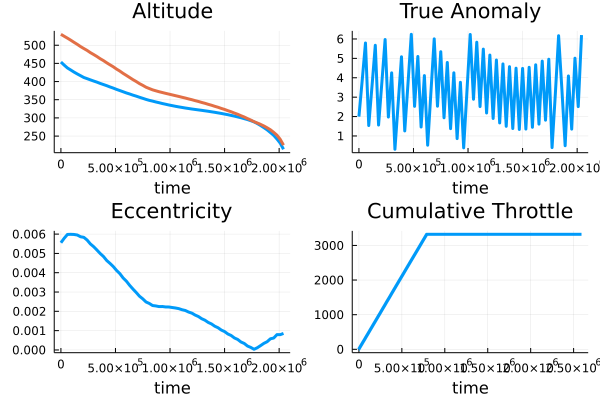

In [6]:
opt_sc = spacecraft(result.minimizer[1], result.minimizer[2])
opt_traj = eval_fitness(opt_sc)
plotCOES(opt_traj)

splt = Plot{Plots.GRBackend() n=23}


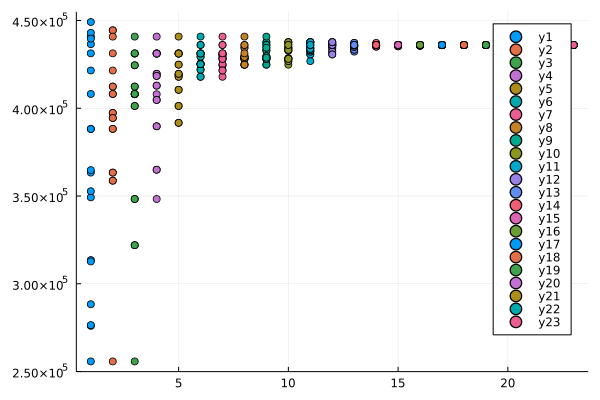

In [7]:
using Plots
gene_hist1 = []
gene_hist2 = []
avg_fit_hist = []
best_fit_hist = []
pop_fit_hist = []
for iteration in result.trace
    population = permutedims(hcat(iteration.metadata["population"]...))
    gene1 = population[:,1]
    gene2 = population[:,2]
    avg_fit = mean(iteration.metadata["state"].fitpop)
    push!(pop_fit_hist, iteration.metadata["state"].fitpop)
    push!(avg_fit_hist, avg_fit)
    push!(best_fit_hist, iteration.value)
    push!(gene_hist1, gene1)
    push!(gene_hist2, gene2)
end

splt = scatter(ones(size(gene_hist1[1])), gene_hist1[1])
for i = 2:length(gene_hist1)
    scatter!(splt, i.*ones(size(gene_hist1[i])), gene_hist1[i])
end
@show splt

splt2 = Plot{Plots.GRBackend() n=23}


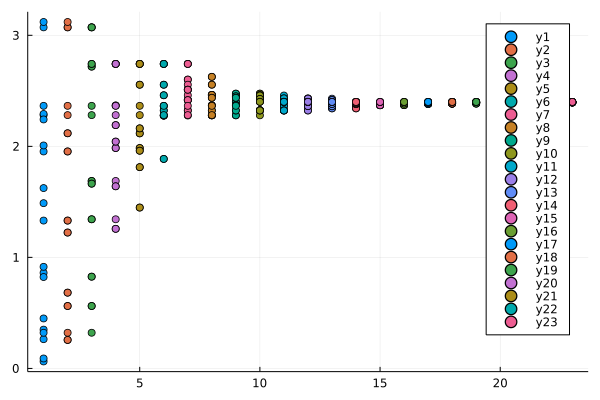

In [8]:
splt2 = scatter(ones(size(gene_hist2[1])), gene_hist2[1])
for i = 2:length(gene_hist2)
    scatter!(splt2, i.*ones(size(gene_hist2[i])), gene_hist2[i])
end
@show splt2

plt = Plot{Plots.GRBackend() n=25}


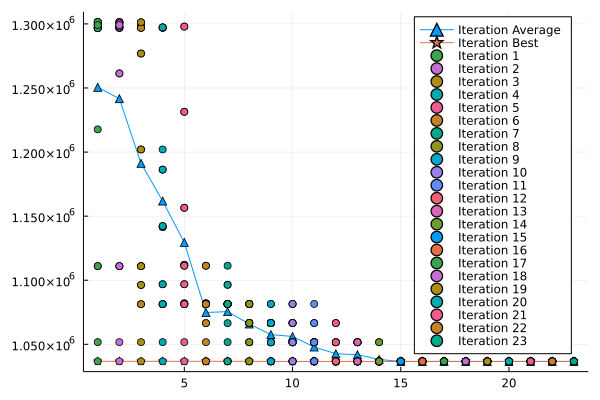

In [9]:
plt = plot(avg_fit_hist, markershape=:^, label="Iteration Average")
plot!(plt, best_fit_hist, markershape=:star, label="Iteration Best")

for i = 1:length(pop_fit_hist)
    scatter!(plt, i.*ones(size(pop_fit_hist[i])), pop_fit_hist[i], label="Iteration " * string(i), legend=:right)
end

@show plt

In [10]:
using JSON
# Save Results
save_dict = Dict("weights" => weights, 
                 "gene1_history" => hcat(gene_hist1...), 
                 "gene2_history" => hcat(gene_hist2...),
                 "pop_fit_hist" => hcat(pop_fit_hist...),
                 )

json_string = JSON.json(save_dict)
open("5050.json","w") do f
  JSON.print(f, json_string, 4)
end